# Neural Network Intro

Welcome to this assignment! We're going to learn some basics about neural networks.

## Tabel of Contents

- 1- Linear Regression
  - 1.1- Gas Station Problem
  - 1.2- Gradient Descent
- 2- Logistic Regression
  - 2.1- Binary Classification
  - 2.2- Softmax Regression
- 3- Neural Network
  - 3.1- Two Layer Neural Network
  - 3-2. Backpropagation
  - 3-3. RNN
- 4- Name Generation (or Shakespeare)
  - 4.1- Input/Output
  - 4.2- Train
  - 4.3- Results

In [1]:
from sklearn.metrics import r2_score
from sklearn.datasets import make_circles

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1- Linear Regression

Consider $f: \mathbb{R} \rightarrow \mathbb{R}$ is a linear function of $x \in \mathbb{R}$. So we can write $f(x) = wx$, where $w$ is an unknown scaler. We don't know the value of $w$, but we have some observed $x, y$ pairs. The task is to predict $w$ based on these datapoints.

### 1.1- Gas Station Problem

We've collected a dataset from [Gas Station No. 240](https://g.co/kgs/3unyyWR). For $4$ lines of this station, we mesured the time each car exits the line. There are $21$ exit times for each line.

We want to convert this dataset to $\mathcal{D}=\{x^{(i)}, y^{(i)}\}_{i=1}^n$ where $x$ denotes the $x$-th car exits from an arbitrary line, and $y$ is the wating time in seconds, starts from exiting the first car of the coherent line. Our goal is to show that there is a linear relationship between $x$ and $y$, i.e., $y=wx$.

Let's load and get familiar with the dataset.

In [2]:
df = pd.read_csv('gas_station_2024_oct_25.csv')
df.head()

,Line 1,Line 2,Line 3,Line 4
0,19:43:45,19:41:50,19:43:57,19:45:14
1,19:44:10,19:42:15,19:44:46,19:45:50
2,19:47:50,19:42:46,19:44:56,19:46:56
3,19:47:55,19:45:36,19:48:31,19:50:52
4,19:48:45,19:47:05,19:50:36,19:50:58


To get $\mathcal{D}$, a little preprocessing is needed. We should convert the time to seconds, and set the exit time for the first car of each line to $0$.

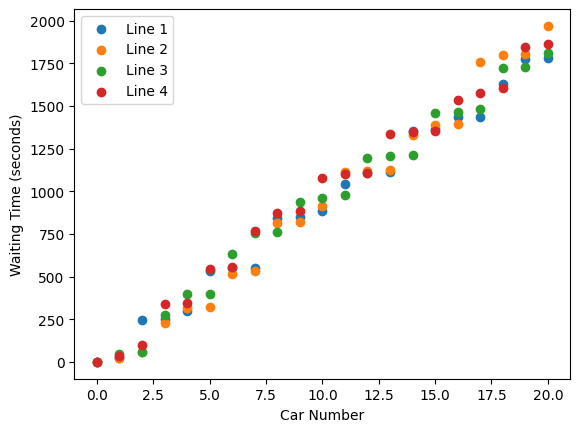

In [3]:
def time_convert(x):
    h, m, s = map(int, x.split(':'))
    return (h * 60 + m) * 60 + s

df = df.map(time_convert)
df = df - df.iloc[0]

for col in df.columns:
    plt.scatter(range(len(df)), df[col], label=col)
plt.xlabel('Car Number')
plt.ylabel('Waiting Time (seconds)')
plt.legend()
plt.show()

Modeling the relationship between $x$ and $y$ as $y=wx$ is appropriate for this problem. There exists a $w \in \mathbb{R}$ that can approximate $y$ reasonably good. By minimizing the cost function
$$ J(w) = \frac{1}{n} \sum_{i=1}^n (wx^{(i)} - y^{(i)})^2
$$
we can find the best $w$.

To ensure the high performance on unseen data, we use first $3$ lines for finding $w$ and the last line for checking the generalization of our model. We call the first and second subset as **training set** and **validation set**, respectively.

In [4]:
x_train = np.concatenate([range(len(df)) for _ in range(3)])
y_train = np.concatenate([df.iloc[:, i] for i in range(3)])

x_val = np.arange(len(df))
y_val = df.iloc[:, -1].values

print('Shapes', x_train.shape, y_train.shape, x_val.shape, y_val.shape)

print(f'Number of training   examples: {len(x_train)}')
print(f'Number of validation examples: {len(x_val)}')

Shapes (63,) (63,) (21,) (21,)
Number of training   examples: 63
Number of validation examples: 21


Use colsed-form normal equation for **Least Squares** to find the best $w$ for the training set.

In [5]:
def closed_form(x, y):
    return np.dot(x, y) / np.dot(x, x)

w = closed_form(x_train, y_train)
print(f'Best value for w: {w:.2f}')

Best value for w: 92.72


Let's plot $J(w)$ for different values of $w$.

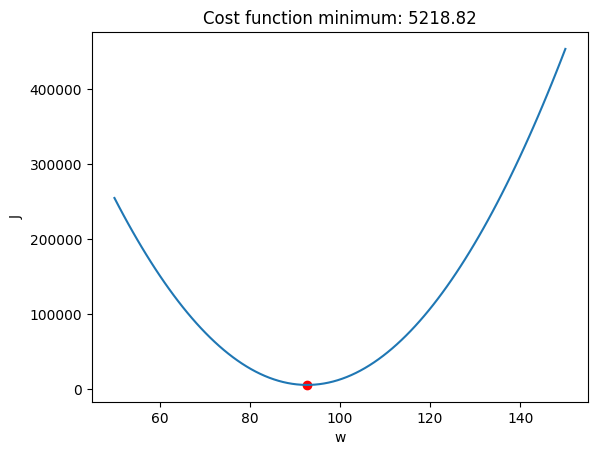

In [6]:
def cost_function(w, x=x_train, y=y_train):
    diff = w * x - y
    n = len(x)
    return np.dot(diff, diff) / n

ws = np.linspace(50, 150, 100)
js = np.array([cost_function(_w) for _w in ws])
j = cost_function(w)

plt.plot(ws, js)
plt.scatter(w, j, c='r')
plt.xlabel('w')
plt.ylabel('J')
plt.title(f'Cost function minimum: {j:.2f}')
plt.show()

A popular metric for linear regression is $R^2$ score. Best possible score is $1$. Use [r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) function from scikit-learn to compute this score for training and validation set.

R2 Score, Train: 0.984, Val: 0.983


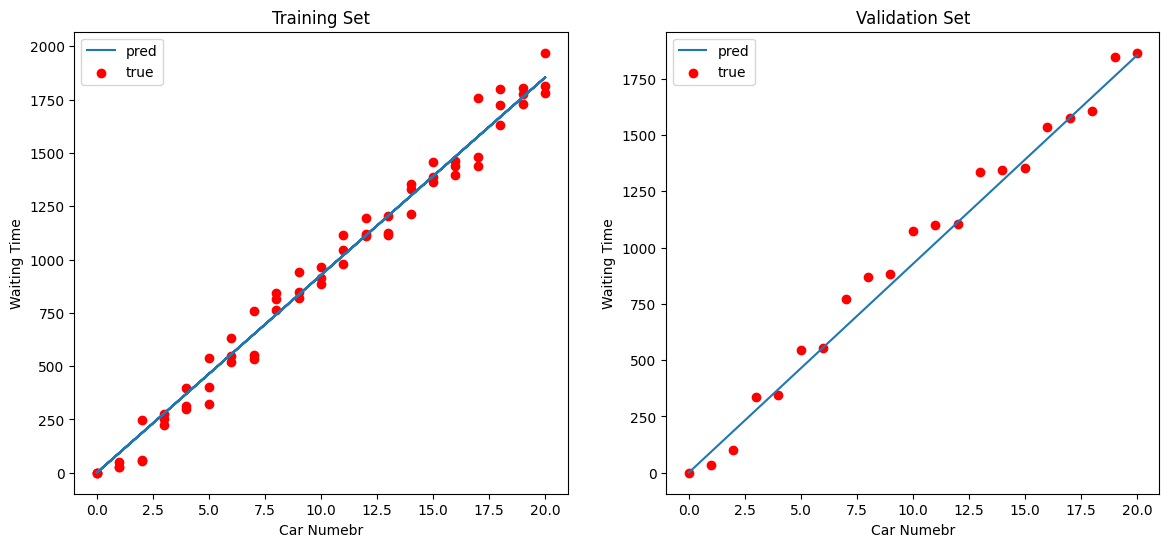

In [7]:
def plot_linear_regression_results(w, x, y_true, ax):
    y_pred = w*x
    r2 = r2_score(y_true, y_pred)
    ax.plot(x, y_pred, label='pred')
    ax.scatter(x, y_true, label='true', c='r')
    ax.set_xlabel('Car Numebr')
    ax.set_ylabel('Waiting Time')
    ax.legend()
    return r2

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

r2_train = plot_linear_regression_results(w, x_train, y_train, axs[0])
axs[0].set_title('Training Set')
r2_val = plot_linear_regression_results(w, x_val, y_val, axs[1])
axs[1].set_title('Validation Set')

print(f'R2 Score, Train: {r2_train:.3f}, Val: {r2_val:.3f}')
plt.show()

Fortunately, our model generalizes very well, since train and val scores are almost equal. Give two reasons why we cannot find a $w$ such that $R^2$ score for **validation set** becomes $1$?

1. Each person in gas station needs an arbitrary amount of petrol and people have different speeds.
2. There are some errors related to time mesurements, about 1 second maybe.

### 1.2- Gradient Descent

Another way of minimizing $J(w)$ is iteratively, taking the derivative of $J$ w.r.t $w$ and step on the opposite direction of $\frac{\partial J(w)}{\partial w}$. This technique is called **Gradient Descent**. There are some *hyperparameters* which we should find appropriate values for them. The most important hyperparameter for this algorithm is *learning rate*. We set it to $0.01$. Also consider *number of iterations* to $10$ for this problem. 

Iteration  1, w: 126.72
Iteration  2, w: 80.26
Iteration  3, w: 97.29
Iteration  4, w: 91.05
Iteration  5, w: 93.34
Iteration  6, w: 92.50
Iteration  7, w: 92.81
Iteration  8, w: 92.69
Iteration  9, w: 92.73
Iteration 10, w: 92.72


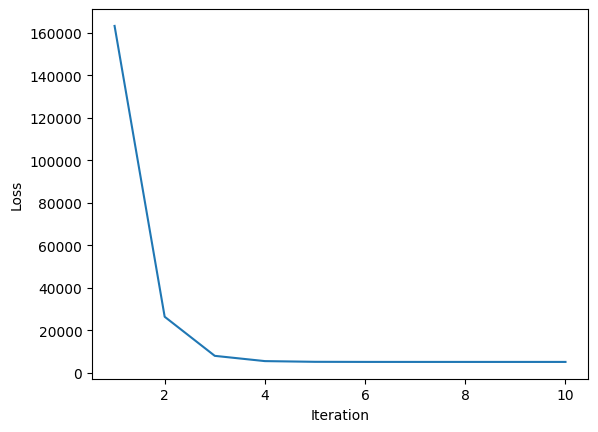

In [ ]:
num_iterations = 10
learning_rate = 1e-2
w = 0
losses = []
n = len(x_train)

for iteration in range(1, num_iterations+1):
    diff = w * x_train - y_train
    dw = np.dot(diff, x_train) / n 
    w = w - learning_rate * dw
    print(f'Iteration {iteration:2d}, w: {w:.2f}')
    loss = cost_function(w)
    losses.append(loss)

plt.plot(range(1, len(losses)+1), losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Unlike closed-form normal equation, gradient descent needs many iterations and hyperparameter tuning. The main reason why gradient descent is used for linear regression is the computational complexity.

What is the order of finding $w$ when using

1. Closed-form normal equation
2. Gradient descent with $T$ iterations

in linear regression? Assume there are $n$ examples in the training set and $x \in \mathbb{R}^k$. Explain your answer. Note that due to these oreders, for large values of $k$, normal equation is computationally expensive.

1. $O(k^2n)$
2. $O(knT)$

## 2- Logistic Regression

Some problems are classification. It means the label $y$ would take on only a small number of discrete values. We first focus on binary classification, then go through multi-class version.

### 2.1- Binary Classification

**Logistic Regression** is a statistical model used for binary classification. It predicts the probability that a given input belongs to a particular class. The key idea is to map the output of a linear model to the range $[0, 1]$ using the **sigmoid function**.

There is a dataset of examples $\mathcal{D} = \{x^{(i)}, y^{(i)}\}_{i=1}^n$ where $x^{(i)} \in \mathbb{R}^2$ and $y^{(i)} \in \{0, 1\}$.

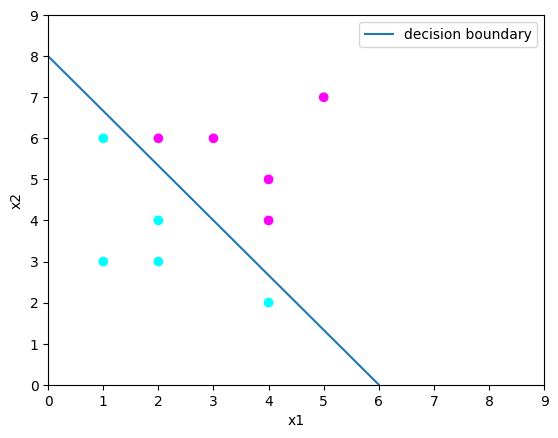

In [43]:
X = np.array([
    [2, 3], [1, 3], [2, 4], [1, 6], [4, 2],
    [4, 5], [5, 7], [3, 6], [4, 4], [2, 6],
])

y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='cool')
plt.plot([0, 6], [8, 0], label='decision boundary')
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(0, 9)
plt.ylim(0, 9)
plt.legend()
plt.show()

It turns out that if a point $x =(x_1, x_2)$ is on top of _decision boundary_ line, its label $y$ is $1$, and $0$ otherwise. By having $X$ and $y$, how can we find _decision boundary_?

It turns out that assigning a probability to each example ($\hat{y} \in [0, 1]$), then set all probabilities lower than $0.5$ to $0$ and otherwise $1$ is a more convenient way of solving this problem. One popular function of mapping $(-\infin, +\infin)$ to $(0, 1)$ is **sigmoid function**, usually shown by $\sigma$. The formula is:

$$
\sigma(z) = \frac{1}{1+e^{-z}}
$$

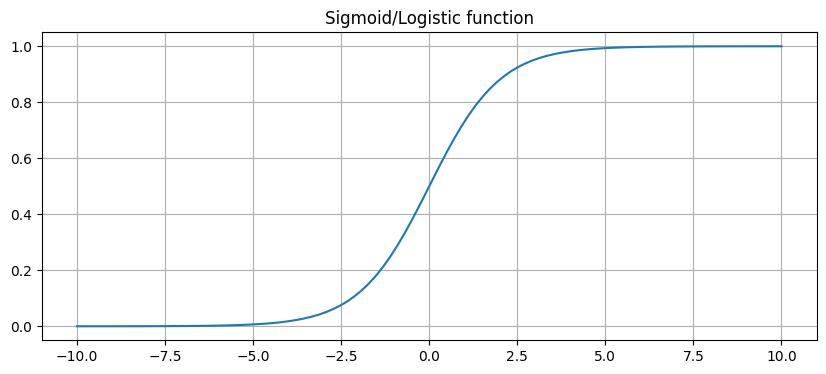

In [44]:
def sigmoid(z: np.ndarray):
    return 1 / (1 + np.exp(-z))
z = np.linspace(-10, 10, 100)
sigma_z = sigmoid(z)

plt.figure(figsize=(10, 4))
plt.plot(z, sigma_z)
plt.grid()
plt.title('Sigmoid/Logistic function')
plt.show()

Now if we set $z = w^Tx + b$, we reach to Logistic Regression, where $w, b$ are our parameters. The loss function is
$$
J = -\sum_{i} \big(y^{(i)}\log \hat{y}^{(i)} + (1 - y^{(i)})\log(1 - \hat{y}^{(i)}) \big)
$$
for Logistic Regression, where $\hat{y}^{(i)} = \sigma(w^Tx^{(i)} + b)$. By finding loss derivatives w.r.t. $w, b$ do Gradient Descent and find the best $w, b$ for this dataset. Note that unlike Linear Regression, there is **no closed-form solution** available for Logistic Regression.

Iteration  1, w: [0.17930767 0.27886259], b: -5.95
Iteration  2, w: [0.35358578 0.54950783], b: -5.90
Iteration  3, w: [0.49065016 0.76027779], b: -5.86
Iteration  4, w: [0.56050989 0.85689859], b: -5.85
Iteration  5, w: [0.59748268 0.8951884 ], b: -5.84
Iteration  6, w: [0.62113056 0.91025468], b: -5.84
Iteration  7, w: [0.63859065 0.91501405], b: -5.84
Iteration  8, w: [0.65285451 0.91484718], b: -5.84
Iteration  9, w: [0.66532816 0.91226323], b: -5.84
Iteration 10, w: [0.67671658 0.90850803], b: -5.85


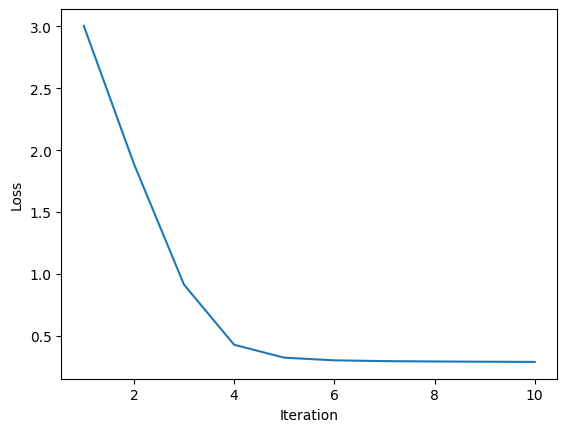

In [63]:
# TODO: find w and b with GD
y = y.reshape(-1, 1)
w = np.zeros((2, 1))
b = np.array([-6.])
learning_rate = 0.01
num_iterations = 10
losses = []
for iteration in range(1, 1+num_iterations):
    y_hat = sigmoid((X @ w) + b)
    loss = -np.mean(y * np.log(y_hat) + (1-y) * np.log(1-y_hat))
    losses.append(loss)
    diff = y_hat - y
    b -= learning_rate * np.sum(diff)
    w -= learning_rate * (X.T @ diff)
    print(f'Iteration {iteration:2d}, w: {w.squeeze()}, b: {b[0]:.2f}')

plt.plot(range(1, len(losses)+1), losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

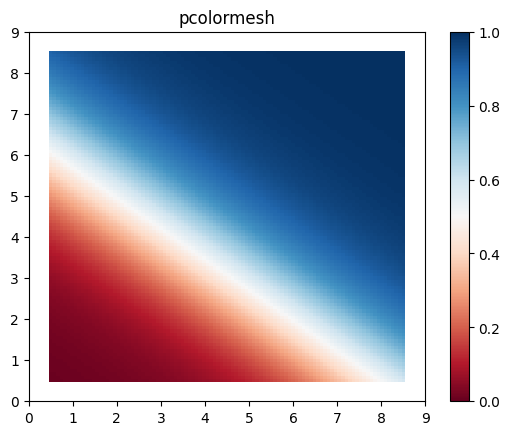

In [64]:
resolution = 100
x1, x2 = np.meshgrid(np.linspace(.5, 8.5, resolution), np.linspace(.5, 8.5, resolution))

X_test = np.hstack([x1.reshape(-1, 1), x2.reshape(-1, 1)])
y_pred = sigmoid((X_test @ w) + b)
y_pred = y_pred.reshape(resolution, resolution)

fig, ax = plt.subplots()

c = ax.pcolormesh(x1, x2, y_pred, cmap='RdBu', vmin=0, vmax=1)
ax.set_title('pcolormesh')
ax.axis([0, 9, 0, 9])
fig.colorbar(c, ax=ax)

plt.show()

Now, consider a dataset which is not linearly seperable.

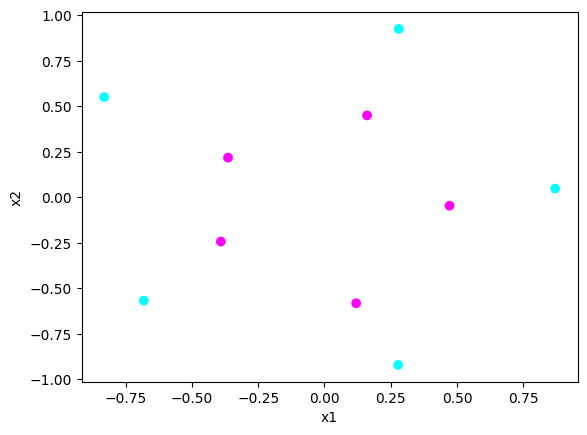

In [22]:
X, y = make_circles(n_samples=10, factor=0.5, noise=0.05, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='cool')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Show that by logistic regression we cannot find decision boundary for this dataset. (*Hint: points where $\hat{y} = 0.5$ is called decision boundary.*)

We come back to this problem later on.

We know that Logistic Regression decision boundary (points where $\hat{y} = 0.5$) is linear:

$$
\frac{1}{1 + e^{-(w^Tx + b)}} = \frac{1}{2} \Rightarrow
w^Tx + b = 0
$$

### 2.3- Softmax Regression

In [70]:
### Define a 3 class classification linear seperable problem.

## 3. Neural Network

Neural Networks consist of several layers, each layer has several small computational units call neurons. Each neuron is very simple and weak to find complex patterns, but by setting these small neurons together, we can make super strong models! Let's go deeper.

### 3.1- Two Layer Neural Network

Logistic Regression is the simplest Neural Network, one layer and one neuron. Each neuron first do a linear operation on its input, then feeds the result to an activation function. We can first find some features from inputs, then feed those valuable features to the logistic model.

Prove that if we don't use non-linear activation function in inner layers, the resulted neural network has the same power as Logistic Regression.

### 3-2. Backpropagation



### 3-3. RNN


# Recurrent Neural Networks (RNNs) and Their Types

## What is an RNN?
A Recurrent Neural Network (RNN) is a type of neural network designed to process sequential data by incorporating feedback connections. Unlike traditional feedforward neural networks, RNNs can retain information from previous inputs through a hidden state, making them well-suited for tasks like time-series analysis, natural language processing, and sequence modeling.

RNNs operate by applying the same set of weights at every time step, allowing them to model dependencies over time. This capability is essential for tasks where context or order matters, such as predicting the next word in a sentence or analyzing stock prices.

### Types of RNN Architectures
1. **One-to-One**  
   This is the standard neural network architecture, where each input maps to a single output.  
   - **Example**: *Image classification*.  
     An image is passed as input, and the output is the class label of the object in the image. For instance, given an image of a dog, the network outputs the label "dog."

   <div align="center">
       <img src="./images/rnn-one-to-one.png" alt="One-to-One RNN" width="300">
   </div>

2. **One-to-Many**  
   This architecture takes a single input and produces a sequence of outputs.  
   - **Example**: *Music generation*.  
     A single starting note or chord is provided as input, and the network generates a sequence of notes to form a melody or song.
   - **Example**: *Image captioning*.  
     An image is provided as input, and the network generates a sequence of words to describe the image, such as "A cat sitting on a mat."
   <div align="center">
       <img src="./images/rnn-one-to-many.png" alt="One-to-Many RNN" width="300">
   </div>

3. **Many-to-One**  
   This architecture processes a sequence of inputs and produces a single output.  
   - **Example**: *Sentiment analysis*.  
     A sentence, such as "The movie was absolutely thrilling," is provided as input, and the network outputs the sentiment, such as "positive."

   <div align="center">
       <img src="./images/rnn-many-to-one.png" alt="Many-to-One RNN" width="300">
   </div>

4. **Many-to-Many (Same Length)**  
   In this architecture, a sequence of inputs generates a sequence of outputs, with each output corresponding to a specific input, and the lengths of input and output sequences are the same.  
   - **Example**: *Video frame labeling*.  
     Each frame of a video sequence is processed to predict corresponding labels, such as "walking," "running," or "jumping" for individual video frames.

   <div align="center">
       <img src="./images/rnn-many-to-many-sync.png" alt="Many-to-Many Same Length RNN" width="300">
   </div>

5. **Many-to-Many (Variable Length)**  
   In this architecture, a sequence of inputs generates a sequence of outputs, but the lengths of the input and output sequences may differ.  
   - **Example**: *Machine translation*.  
     A sentence in one language, such as "What is your name?", is provided as input, and the network generates the translated sentence in another language, such as "¿Cómo te llamas?" in Spanish.

   <div align="center">
       <img src="./images/rnn-many-to-many-async.png" alt="Many-to-Many Variable Length RNN" width="300">
   </div>


The versatility of RNNs across these architectures enables them to address a wide range of sequence-related tasks, from classification to sequence generation and translation. Each architecture is tailored to the specific requirements of the task at hand, making RNNs a foundational tool in deep learning for sequential data.


## The Way Input is Processed in RNNs

In an RNN, the input is typically processed sequentially over discrete time steps. At each time step $t$, the RNN receives:
- $x_t$: the input at the current time step.
- $h_{t-1}$: the hidden state from the previous time step.

The RNN updates its hidden state $h_t$ based on $x_t$ and $h_{t-1}$ using a shared set of weights across all time steps. This mechanism allows the network to "remember" past information while processing new inputs.


# Forward Function on a Many-to-Many RNN

In a "Many-to-Many" RNN, both the input and output are sequences. For example, in machine translation, each word in the input sentence corresponds to a translated word in the output sentence.

### Key Steps in the Forward Pass:
1. Initialize the hidden state $h_0$ (usually as a vector of zeros).
2. For each time step $t$:
   - Compute the hidden state $h_t$ using the current input $x_t$ and previous hidden state $h_{t-1}$.
   - Compute the output $y_t$ from the hidden state $h_t$.

The formulas are:

$h_t = \sigma(W_h \cdot x_t + U_h \cdot h_{t-1} + b_h)$

$y_t = \text{softmax}(W_y \cdot h_t + b_y)$

Where:
- $W_h, U_h, b_h$: Weights and biases for the hidden state.
- $W_y, b_y$: Weights and biases for the output.
- $\sigma$: Activation function (e.g., tanh or ReLU).


In [4]:
# Define forward function for Many-to-Many RNN
def many_to_many_rnn_forward(X, W_h, U_h, b_h, W_y, b_y):
    """
    Forward pass for a Many-to-Many RNN.

    Parameters:
    - X: Input sequence of shape (T, input_dim), where T is the sequence length
    - W_h, U_h, b_h: Weights and biases for hidden state computation
    - W_y, b_y: Weights and biases for output computation

    Returns:
    - outputs: Output sequence of shape (T, output_dim)
    """
    T, input_dim = X.shape
    hidden_dim = W_h.shape[1]
    output_dim = W_y.shape[1]

    # Initialize hidden state
    h_t = np.zeros((hidden_dim,))
    outputs = []

    # Forward pass
    for t in range(T):
        x_t = X[t]
        h_t = np.tanh(np.dot(W_h, x_t) + np.dot(U_h, h_t) + b_h)
        y_t = np.dot(W_y, h_t) + b_y
        outputs.append(y_t)

    return np.array(outputs)


# Implementing a Variable-Sized Many-to-Many RNN from Scratch with PyTorch

## 0. Activation Functions and Gradient Vanishing
### Overview of Activation Functions
Activation functions introduce non-linearity into neural networks, which allows them to learn complex patterns. The choice of activation function can impact performance and convergence.

#### Common Activation Functions:
1. **Sigmoid**  
   - Formula:  
     
     $\sigma(x) = \frac{1}{1 + e^{-x}}$

   - Output range: (0, 1)
   - Issues: Prone to **vanishing gradients** for large/small inputs.
   - Use case: Probabilistic outputs (e.g., binary classification).

2. **Tanh**  
   - Formula:  
     
     $\text{tanh}(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$
   - Output range: (-1, 1)
   - Issues: Still susceptible to **vanishing gradients**, though better than sigmoid.

3. **ReLU (Rectified Linear Unit)**  
   - Formula:  
     
     $f(x) = \max(0, x)$
   - Output range: [0, ∞)
   - Benefits: Avoids vanishing gradients; faster convergence.
   - Issue: **Dying neurons** (when many activations are 0).



In [5]:
import torch
import torch.nn.functional as F

# Example activations
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])

# Sigmoid
sigmoid_output = torch.sigmoid(x)

# Tanh
tanh_output = torch.tanh(x)

# ReLU
relu_output = F.relu(x)

print("Sigmoid Output:", sigmoid_output)
print("Tanh Output:", tanh_output)
print("ReLU Output:", relu_output)

Sigmoid Output: tensor([0.1192, 0.2689, 0.5000, 0.7311, 0.8808])
Tanh Output: tensor([-0.9640, -0.7616,  0.0000,  0.7616,  0.9640])
ReLU Output: tensor([0., 0., 0., 1., 2.])


# Forward Pass

## What is a Forward Pass?

The forward pass involves calculating the output of the network for a given input. For an RNN:

- **Encoder**: Processes the input sequence `{x₁, x₂, ..., xₜ}`, updating its hidden state at each step.
- **Decoder**: Generates outputs `{y₁, y₂, ..., yₜ}` from the encoder's final hidden state.

## Forward Pass Steps

1. **Initialize hidden states.**
2. **Iterate through the input sequence.**
3. **Use hidden states and inputs to compute outputs via activation functions.**


In [ ]:
class RNN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.hidden_dim = hidden_dim
        
        # Weight matrices
        self.Wxh = torch.randn(input_dim, hidden_dim, requires_grad=True)
        self.Whh = torch.randn(hidden_dim, hidden_dim, requires_grad=True)
        self.Why = torch.randn(hidden_dim, output_dim, requires_grad=True)
        
        # Bias terms
        self.bh = torch.zeros(hidden_dim, requires_grad=True)
        self.by = torch.zeros(output_dim, requires_grad=True)

    def forward(self, inputs):
        h = torch.zeros(self.hidden_dim)  # Initialize hidden state
        outputs = []

        for x in inputs:
            h = torch.tanh(x @ self.Wxh + h @ self.Whh + self.bh)  # Hidden state
            y = h @ self.Why + self.by  # Output
            outputs.append(y)

        return outputs


## 2. Backpropagation Function

### What is Backpropagation?

Backpropagation is the process of updating the model parameters (weights and biases) by computing the gradient of the loss function with respect to each parameter. This is done using the chain rule of calculus to propagate errors backward through the network. In the context of RNNs, backpropagation involves two primary components:

- **Decoder**: Calculates gradients for the output.
- **Encoder**: Propagates gradients backward through the hidden states over time.

The overall goal is to compute gradients for each model parameter and update them in a way that minimizes the loss function.

## Chain Rule in RNNs

In an RNN, the gradients are computed recursively at each time step. The chain rule is applied multiple times to compute the gradient with respect to the parameters:
   <div align="center">

$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial h} \cdot \frac{\partial h}{\partial W}$
    </div>
    
Where:

- $L$ is the loss function.
- $W$ represents the model parameters (weights).
- $y$ is the output of the network.
- $h$ is the hidden state.

At each time step, we need to compute the derivative of the loss with respect to the weights and propagate the gradients backward through the hidden states.


### Backpropagation in RNN:

In an RNN, the gradients are computed recursively at each time step. The chain rule of calculus is applied multiple times to compute the gradient with respect to the parameters at each time step. For a given time step $t$, the loss $L_t$ is computed, and the gradients are propagated backward through the network starting from the decoder and moving through the encoder's hidden states.

The loss function $L$ depends on the output $y_t$, the hidden state $h_t$, and the weights and biases. The core of the backpropagation process involves computing the following:

- The gradient of the loss with respect to the output: $\frac{\partial L}{\partial y_t}$
- The gradient of the loss state with respect to the hidden state: $\frac{\partial L}{\partial h_t}$
- The gradient of the loss with respect to the weights and biases: $\frac{\partial L}{\partial W}$ and $\frac{\partial L}{\partial b}$

The backpropagation process in RNNs is done in two stages:

1. **Decoder**: Compute the gradients of the output layer (decoder).
2. **Encoder**: Compute the gradients for the hidden states and propagate them backward through the time steps.


### Step-by-Step Explanation of the Backpropagation Process

#### 1. Backpropagation through the Decoder

The decoder computes the gradient of the loss with respect to the output of the RNN at each time step. This involves:

- Calculating the error at each time step $t$:
  
<div align="center">

  $d y_t = y_t - \hat{y}_t$  

</div>

  where $\hat{y}_t$ is the true output and $y_t$ is the predicted output.

- Then, we compute the gradients with respect to the weight matrices that map from the hidden state to the output:

    <div align="center">

  $\frac{\partial L}{\partial W_{hy}} = \sum_t h_t^T \cdot d y_t$
  
  $\frac{\partial L}{\partial b_y} = \sum_t d y_t$

    <div>

#### 2. Backpropagation through the Encoder

The encoder computes the gradient of the loss with respect to the hidden states. The chain rule is used to propagate the gradient backward through time:

- Starting with the last time step $T$, we calculate the gradient of the loss with respect to the last hidden state:

    <div align="center">

  $\frac{\partial L}{\partial h_T} = \frac{\partial L}{\partial y_T} \cdot \frac{\partial y_T}{\partial h_T}$
    </div>

  Here, $\frac{\partial y_T}{\partial h_T} = W_{hy}$, and this is propagated backward through time to calculate the gradients for each earlier hidden state.

- Gradients are passed through the non-linearity (e.g., Tanh or Sigmoid) at each step, which affects the way the gradients are propagated backward. For example, using Tanh:


<div align="center">

  $\frac{\partial L}{\partial h_t} = \frac{\partial L}{\partial h_{t+1}} \cdot \left( \frac{\partial h_t}{\partial h_{t+1}} \right)$

<div>

  The derivative of $h_t$ with respect to $h_{t+1}$ can be computed using the derivative of the activation function:

  <div align="center", size="20px">

  $\frac{\partial h_{t+1}}{\partial h_t} = (1 - h_t^2)$
  </div>

Once the gradients for the hidden states are computed, we can compute the gradients with respect to the parameters in the encoder, which include the weights $W_{xh}$, $W_{hh}$, and the bias $b_h$. These can be computed as follows:

  <div align="center">

$\frac{\partial L}{\partial W_{xh}} = \sum_t x_t^T \cdot d h_t$


$\frac{\partial L}{\partial W_{hh}} = \sum_t h_{t-1}^T \cdot d h_t$


$\frac{\partial L}{\partial b_h} = \sum_t d h_t$

  </div>


In [6]:
class RNN:
    # (As defined in Forward Pass)

    def backward(self, inputs, targets, outputs, learning_rate=0.01):
        # Initialize gradients
        dWxh = torch.zeros_like(self.Wxh)
        dWhh = torch.zeros_like(self.Whh)
        dWhy = torch.zeros_like(self.Why)
        dbh = torch.zeros_like(self.bh)
        dby = torch.zeros_like(self.by)
        
        # Output gradients (decoder)
        dh_next = torch.zeros_like(self.bh)
        for t in reversed(range(len(inputs))):
            dy = outputs[t] - targets[t]  # Error at time t
            dWhy += outputs[t].T @ dy
            dby += dy
            
            dh = dy @ self.Why.T + dh_next
            dh_raw = (1 - outputs[t] ** 2) * dh  # Tanh derivative
            
            dWxh += inputs[t].T @ dh_raw
            dWhh += dh_next.T @ dh_raw
            dbh += dh_raw
            dh_next = dh_raw @ self.Whh.T
        
        # Update weights
        for param, dparam in zip([self.Wxh, self.Whh, self.Why, self.bh, self.by],
                                 [dWxh, dWhh, dWhy, dbh, dby]):
            param -= learning_rate * dparam
